In [38]:
import numpy as np
from scipy.integrate import odeint
import scipy.stats
import matplotlib.pyplot as plt
import copy

In [39]:
import aekf

In [40]:
# Import functions directly from github
# Important: note that we use raw.githubusercontent.com, not github.com

import requests
url = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/plot_utility.py'
r = requests.get(url)

# Store the file to the colab working directory
with open('plot_utility.py', 'w') as f:
    f.write(r.text)

# import the function we want from that file
from plot_utility import plot_tme

# Simulate System

In [41]:
# System Parameters
m = 2 # mass
l = 0.2 # distance from rotor to COM
#I = 2/5*m*l**2 # Moment of inertia (Iyy) -- assuming drone is a sphere (it is not)
g = 9.81 # gravity constant

# Control Parameters
tau_k_theta = 10 # torque control to stabilize theta
tau_k_thetadot = 20 # torque control to provide thetadot damping
tau_k_x = 0.01 # torque control to control x position
tau_k_xdot = 0.2 # torque control to provide xdot damping
F_k_z = 1000 # Force control to control z position
F_k_zdot = 10000 # Force control to control z position

# Noise for measurements:
v = [0.01, 0.001, 0.2, 0.2]

In [42]:
def desired_trajectory(t):
    theta_des = 0*np.ones_like(t)
    z_des = 1.7*np.sin(0.02*t)+1.75
    x_des = 3*np.sin(0.05*t)
    return theta_des, x_des, z_des

### Nominal trajectory, measurements

In [43]:
class PlanarDrone:
    def __init__(self):
        self.v = [0.01, 0.001, 0.2, 0.2]

    def control(self, X, t):
        theta, thetadot, x, xdot, mu, mudot = X

        # desired trajectory
        theta_des, x_des, z_des = desired_trajectory(t)

        z = 1/mu
        zdot = -mudot*z**2
        
        # error
        x_err = x_des - x
        z_err = (z_des - z)

        # control
        tau = -(tau_k_x*x_err - tau_k_xdot*xdot)  + (tau_k_theta*(-theta) - tau_k_thetadot*thetadot)
        Fz = (F_k_z*z_err - F_k_zdot*zdot)
        
        return Fz, tau

    def f(self, X, t):
        theta, thetadot, x, xdot, mu, mudot = X
        I = 2/5*m*l**2
        
        z = 1/mu
        zdot = -mudot*z**2

        # control
        F, tau = self.control(X, t)

        # dynamics
        d_theta = thetadot
        d_thetadot = tau/I
        d_x = xdot
        d_xdot = -F*np.sin(theta)/m
        
        d_z = zdot
        d_zdot = (F*np.cos(theta)-m*g)/m
        
        d_mu = mudot
        d_mudot = -1*( d_zdot + 2*z*zdot*mudot) / z**2

        d_x = [d_theta, d_thetadot, d_x, d_xdot, d_mu, d_mudot]

        return d_x

    def h(self, x, u, t):
        theta, thetadot, x, xdot, mu, mudot = x
        
        F = u[0,:]
        
        xddot_direct = -F*np.sin(theta)/m
        
        z = 1/mu
        zdot = -mudot*z**2
        d_zdot = (F*np.cos(theta)-m*g)/m
        muddot_direct = -1*( d_zdot + 2*z*zdot*mudot) / z**2
        

        y = np.array([theta, thetadot, xdot*mu, xddot_direct, d_zdot])

        return y

    def simulate(self, x0, tsim):
        result = odeint(self.f, x0, tsim)
        X = result.T
        U = np.atleast_2d(self.control(X, tsim))
        Y = self.h(X, U, tsim)
        return X, U, Y

In [44]:
sys = PlanarDrone()

x0 = np.hstack(([(np.random.random()-0.5)*1e-3 for i in range(4)], 3, 0))
#x0 = np.hstack((x0, 0.5))
tsim = np.arange(0, 400, 0.1)

X, U, Y = sys.simulate(x0, tsim)

In [45]:
# throw away first point.. it is weird

X = X[:,1:]
U = U[:,1:]
Y = Y[:,1:]
tsim = tsim[1:]

In [46]:
print(X.shape)
print(Y.shape)
print(U.shape)

(6, 3999)
(5, 3999)
(2, 3999)


In [47]:
theta = X[0, :]
x = X[2, :]
mu = X[4, :]

theta_dot = X[1, :]
x_dot = X[3, :]
mu_dot = X[5, :]

theta_des, x_des, z_des = desired_trajectory(tsim)
mu_des = 1/z_des

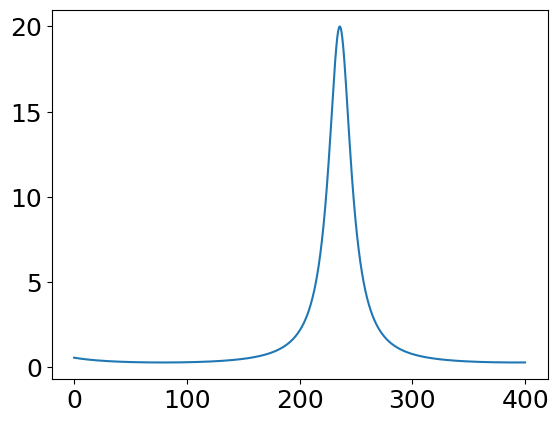

In [48]:
plt.plot(tsim, 1/z_des, label='z_des')

<Axes: xlabel='Time', ylabel='mu'>

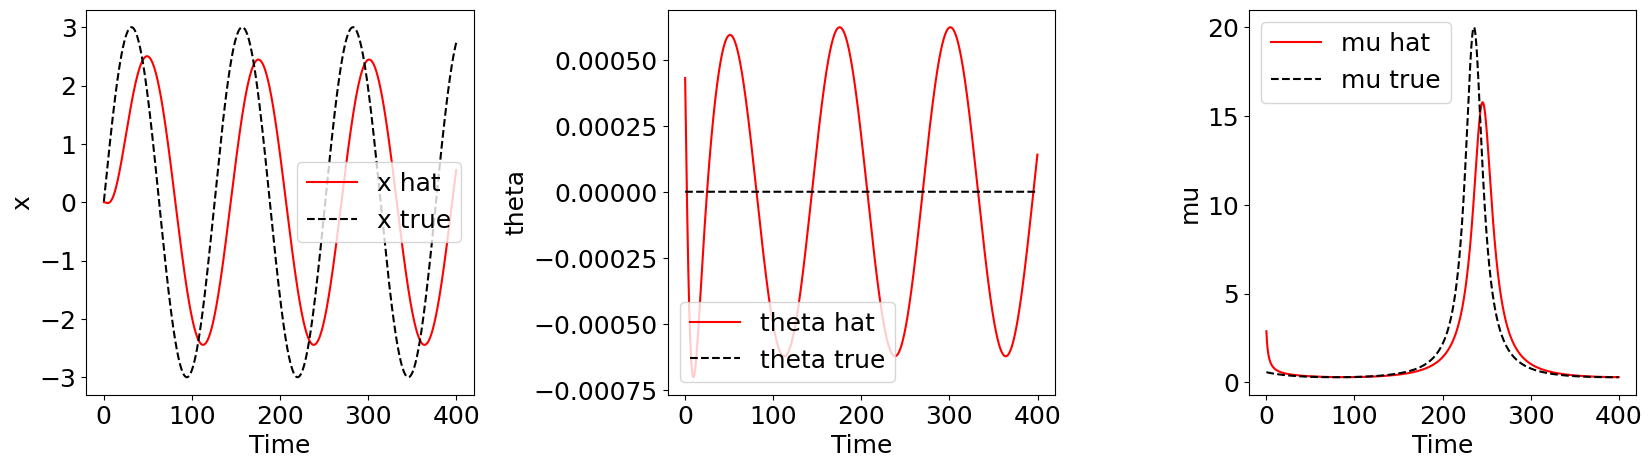

In [49]:
fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=0.5)


ax1 = fig.add_subplot(131)
plot_tme(tsim, x_des, None, x, label_var='x', ax=ax1)

ax2 = fig.add_subplot(132)
plot_tme(tsim, theta_des, None, theta, label_var='theta', ax=ax2)

ax3 = fig.add_subplot(133)
plot_tme(tsim, mu_des, None, mu, label_var='mu', ax=ax3)

Add noise to measurements

In [50]:
v = np.array([0.01, 0.001, 0.05, 0.0001, 0.0001])
noise = np.array( [np.random.normal(0, vi, Y.shape[1]) for vi in v] )

In [82]:
Ynoisy = Y + noise
print(Ynoisy.shape)

(5, 3999)


(-0.5, 0.5)

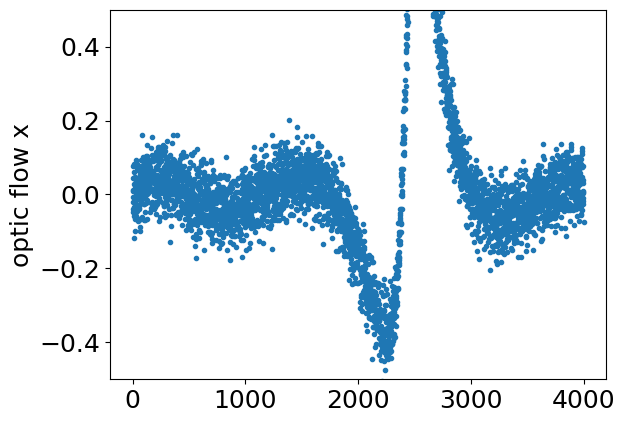

In [52]:
plt.plot(Ynoisy[2,:], '.')
plt.ylabel('optic flow x')
plt.ylim(-.5,.5)

Text(0, 0.5, 'Accel x')

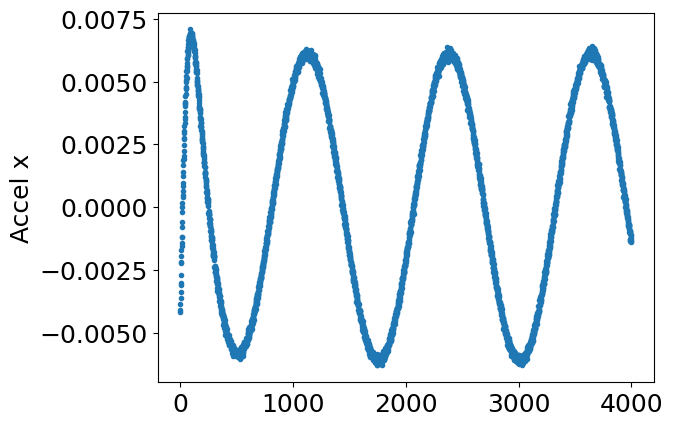

In [53]:
plt.plot(Ynoisy[3,:], '.')
#plt.ylim(-.05,.05)
plt.ylabel('Accel x')

In [54]:
X.shape

(6, 3999)

# Regular EKF, INCORRECT mass, constant z-velocity model

In [55]:
x0.shape

(6,)

In [56]:
# Initial conditions

x0 = [(np.random.random()-0.5)*1e-3 for i in range(6)]
x0[4] = 5
x0[5] = 0
x0 = np.atleast_2d(x0).T
P0 = 1e-6*np.eye(len(x0))

# Noise defined by measurement noise
R = np.diag( np.hstack([v[0:-1]**2]) )

print(R)

# Fairly accurate model
Q = 5e-8*np.eye(x0.shape[0])
Q[5,5] = 1e-5

[[1.0e-04 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 1.0e-06 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 2.5e-03 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 1.0e-08]]


In [57]:
# determines how much the x and z acceleration are used in the model 
alpha_x = 1
alpha_z = 0

In [58]:
constraints = {4: {'high': 100, # mu
                   'low': 0.1},
               5: {'high': 5,   # mudot
                   'low': -5}}

In [59]:
def f_d(X, U):
    dt=0.1
    theta, thetadot, x, xdot, mu, mudot = np.ravel(X)
    m = 1.5 ## << true value is 2
    I = 2/5*m*l**2
    F, tau = np.ravel(U)
    
    z = 1/mu
    zdot = -mudot*z**2
    d_zdot = (F*np.cos(theta))/m - g
    d_mudot = -1*( d_zdot + 2*z*zdot*mudot) / z**2
        
    new_theta = theta + thetadot*dt
    new_thetadot = tau/I
    new_x = x + xdot*dt
    new_xdot = xdot + alpha_x*(-F*np.sin(theta)/m*dt)
    new_mu = mu + mudot*dt
    new_mudot = mudot + alpha_z*d_mudot*dt

    new_x = np.atleast_2d(np.array([new_theta, new_thetadot, new_x, new_xdot, new_mu, new_mudot])).T

    return new_x

def h_d(X, U):
    theta, thetadot, x, xdot, mu, mudot = np.ravel(X)
    
    F = np.ravel(U)[0]
    xddot_direct = -F*np.sin(theta)/m
    
    z = 1/mu
    zdot = -mudot*z**2
    d_zdot = (F*np.cos(theta)-m*g)/m
    muddot_direct = -1*( d_zdot + 2*z*zdot*mudot) / z**2

    y = np.atleast_2d(np.array([theta, thetadot, xdot*mu, xddot_direct])).T

    return y

def get_y_aug(y, xhat, u):
    muhat = y[2,0] / xhat[3,0]
    y_aug = np.vstack((y, muhat))
    return y_aug

def get_R(R, y, xhat, u):
    R[4,4] = (1/np.abs(xhat[3,0]))**2*1e-1
    return R

In [60]:
xhat, P, s = aekf.ekf(Ynoisy[0:-1,:], x0, f_d, h_d, Q, R, U, P0=P0,
                      get_y_aug=None, get_R=None, constraints=constraints, ignore_nan=False)

In [61]:
theta_hat = xhat[0, :]
x_hat = xhat[2, :]
mu_hat = xhat[4, :]

theta_dot_hat = xhat[1, :]
x_dot_hat = xhat[3, :]
mu_dot_hat = xhat[5, :]

(0.0, 5.0)

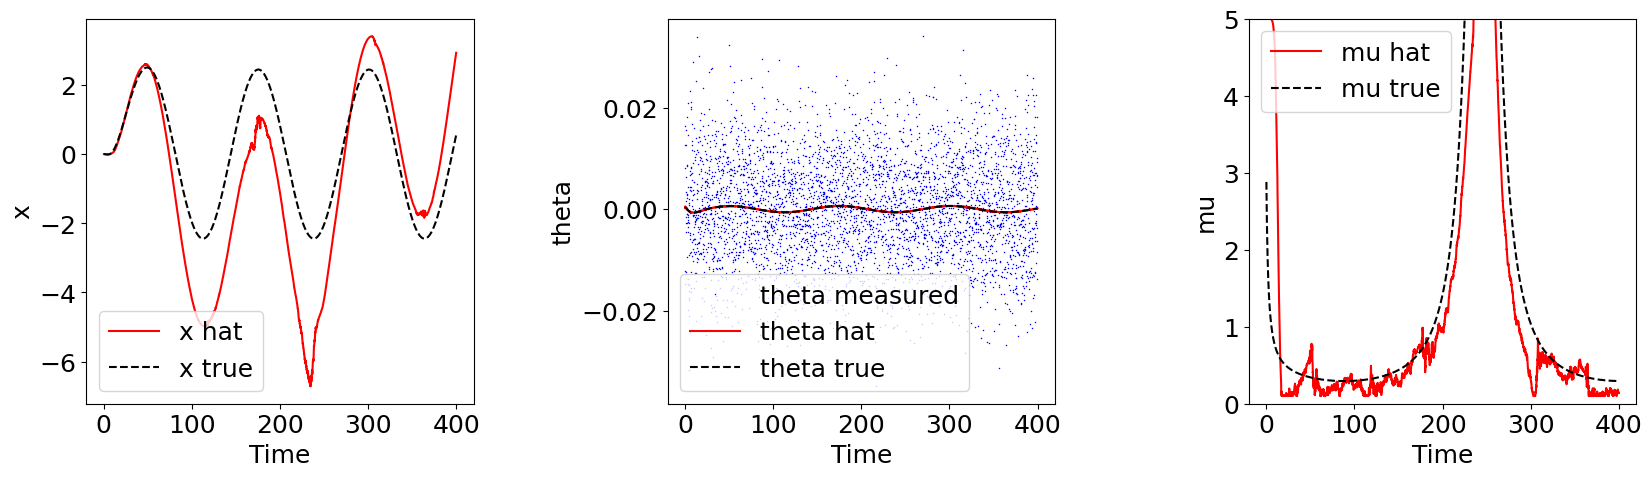

In [62]:
fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=0.5)


ax1 = fig.add_subplot(131)
plot_tme(tsim, x, None, x_hat, label_var='x', ax=ax1)

ax2 = fig.add_subplot(132)
plot_tme(tsim, theta, Ynoisy[0,:], theta_hat, label_var='theta', ax=ax2)

ax3 = fig.add_subplot(133)
plot_tme(tsim, mu, None, mu_hat, label_var='mu', ax=ax3)
ax3.set_ylim(0,5)

(-1.0, 1.0)

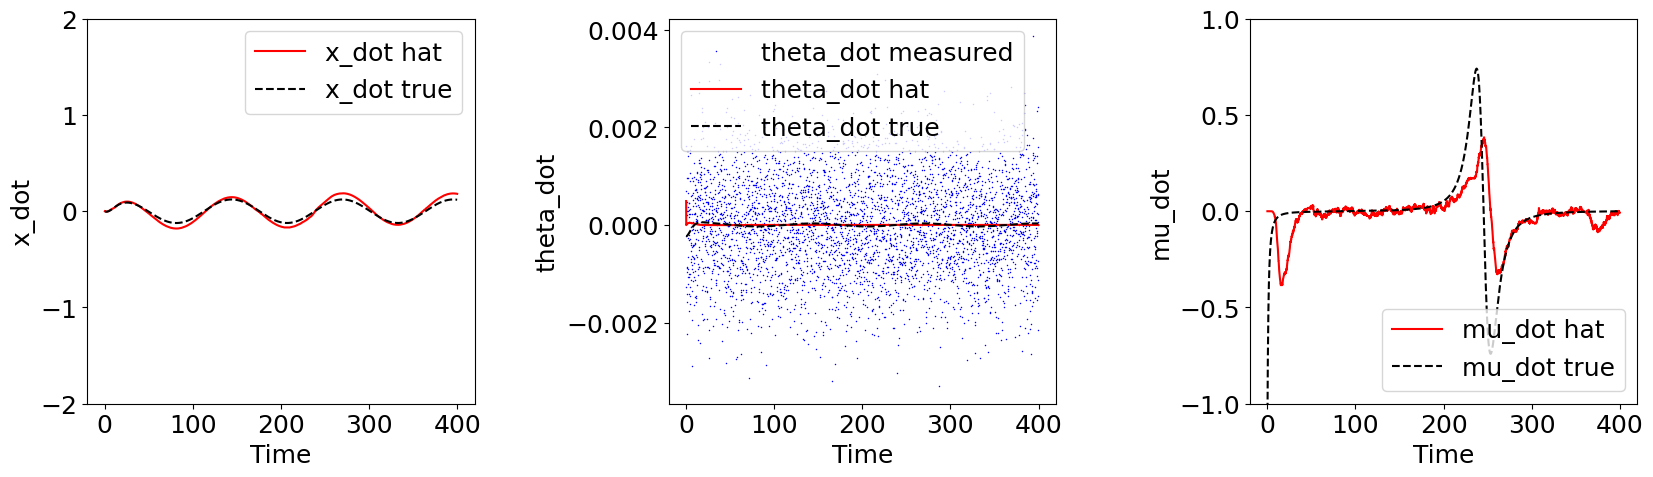

In [63]:
fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=0.5)


ax1 = fig.add_subplot(131)
plot_tme(tsim, x_dot, None, x_dot_hat, label_var='x_dot', ax=ax1)
ax1.set_ylim(-2,2)

ax2 = fig.add_subplot(132)
plot_tme(tsim, theta_dot, Ynoisy[1,:], theta_dot_hat, label_var='theta_dot', ax=ax2)

ax3 = fig.add_subplot(133)
plot_tme(tsim, mu_dot, None, mu_dot_hat, label_var='mu_dot', ax=ax3)
ax3.set_ylim(-1, 1)

# Augmented EKF, INCORRECT mass, constant z-velocity model

In [64]:
x0.shape

(6, 1)

In [65]:
# Initial conditions

x0 = [(np.random.random()-0.5)*1e-3 for i in range(6)]
x0[4] = 5
x0[5] = 0
x0 = np.atleast_2d(x0).T
P0 = 1e-6*np.eye(len(x0))

# Noise defined by measurement noise
R = np.diag( np.hstack([v[0:-1]**2, 1e-3]) )
print(R.shape)

# Fairly accurate model
Q = 5e-8*np.eye(x0.shape[0])
Q[5,5] = 1e-5

(5, 5)


In [66]:
# determines how much the x and z acceleration are used in the model 
alpha_x = 1
alpha_z = 0

In [67]:
constraints = {4: {'high': 100, # mu
                   'low': 0.1},
               5: {'high': 5,   # mudot
                   'low': -5}}

In [68]:
def f_d(X, U):
    dt=0.1
    theta, thetadot, x, xdot, mu, mudot = np.ravel(X)
    m = 1.5 ## << true value is 2
    I = 2/5*m*l**2
    F, tau = np.ravel(U)
    
    z = 1/mu
    zdot = -mudot*z**2
    d_zdot = (F*np.cos(theta))/m - g
    d_mudot = -1*( d_zdot + 2*z*zdot*mudot) / z**2
        
    new_theta = theta + thetadot*dt
    new_thetadot = tau/I
    new_x = x + xdot*dt
    new_xdot = xdot + alpha_x*(-F*np.sin(theta)/m*dt)
    new_mu = mu + mudot*dt
    new_mudot = mudot + alpha_z*d_mudot*dt

    new_x = np.atleast_2d(np.array([new_theta, new_thetadot, new_x, new_xdot, new_mu, new_mudot])).T

    return new_x

def h_d(X, U):
    theta, thetadot, x, xdot, mu, mudot = np.ravel(X)
    
    F = np.ravel(U)[0]
    xddot_direct = -F*np.sin(theta)/m
    
    z = 1/mu
    zdot = -mudot*z**2
    d_zdot = (F*np.cos(theta)-m*g)/m
    muddot_direct = -1*( d_zdot + 2*z*zdot*mudot) / z**2

    y = np.atleast_2d(np.array([theta, thetadot, xdot*mu, xddot_direct, mu])).T

    return y

def get_y_aug(y, xhat, u):
    muhat = y[2,0] / xhat[3,0]
    y_aug = np.vstack((y, muhat))
    return y_aug

def get_R(R, y, xhat, u):
    R[4,4] = (1/np.abs(xhat[3,0]))**2*1e-4
    return R

In [69]:
xhat, P, s = aekf.ekf(Ynoisy[0:-1,:], x0, f_d, h_d, Q, R, U, P0=P0,
                      get_y_aug=get_y_aug, get_R=get_R, constraints=constraints)

In [70]:
theta_hat = xhat[0, :]
x_hat = xhat[2, :]
mu_hat = xhat[4, :]

theta_dot_hat = xhat[1, :]
x_dot_hat = xhat[3, :]
mu_dot_hat = xhat[5, :]

(0.0, 5.0)

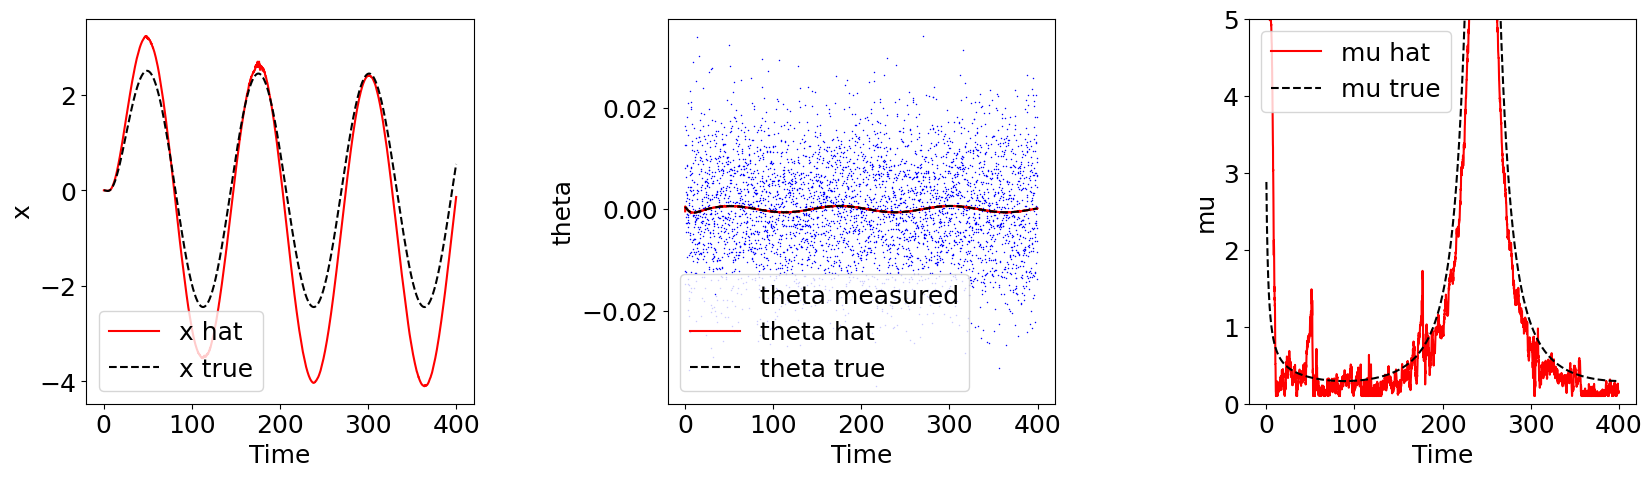

In [71]:
fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=0.5)


ax1 = fig.add_subplot(131)
plot_tme(tsim, x, None, x_hat, label_var='x', ax=ax1)

ax2 = fig.add_subplot(132)
plot_tme(tsim, theta, Ynoisy[0,:], theta_hat, label_var='theta', ax=ax2)

ax3 = fig.add_subplot(133)
plot_tme(tsim, mu, None, mu_hat, label_var='mu', ax=ax3)
ax3.set_ylim(0,5)

(-1.0, 1.0)

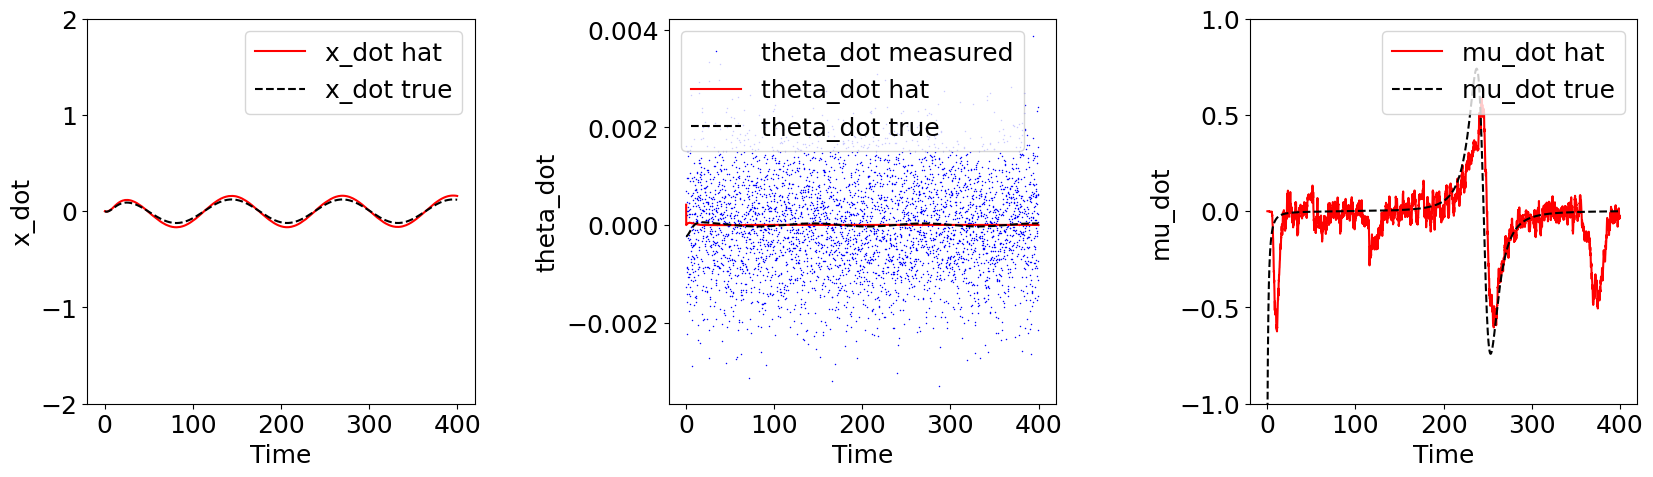

In [72]:
fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=0.5)


ax1 = fig.add_subplot(131)
plot_tme(tsim, x_dot, None, x_dot_hat, label_var='x_dot', ax=ax1)
ax1.set_ylim(-2,2)

ax2 = fig.add_subplot(132)
plot_tme(tsim, theta_dot, Ynoisy[1,:], theta_dot_hat, label_var='theta_dot', ax=ax2)

ax3 = fig.add_subplot(133)
plot_tme(tsim, mu_dot, None, mu_dot_hat, label_var='mu_dot', ax=ax3)
ax3.set_ylim(-1, 1)

# Augmented EKF, mass a state, constant z-velocity model

In [73]:
x0.shape

(6, 1)

In [74]:
# Initial conditions

x0 = [(np.random.random()-0.5)*1e-3 for i in range(7)]
x0[4] = 5
x0[5] = 0
x0[6] = 1
x0 = np.atleast_2d(x0).T
P0 = 1e-6*np.eye(len(x0))

# Noise defined by measurement noise
R = np.diag( np.hstack([v[0:-1]**2, 1e-3]) )

# Fairly accurate model
Q = 5e-8*np.eye(x0.shape[0])
Q[5,5] = 1e-5

In [75]:
# determines how much the x and z acceleration are used in the model 
alpha_x = 1
alpha_z = 0

In [76]:
constraints = {4: {'high': 100, # mu
                   'low': 0.01},
               5: {'high': 5,   # mudot
                   'low': -5}}

In [77]:
def f_d(X, U):
    dt=0.1
    theta, thetadot, x, xdot, mu, mudot, m = np.ravel(X)
    #m = 1.5 ## << true value is 2
    I = 2/5*m*l**2
    F, tau = np.ravel(U)
    
    z = 1/mu
    zdot = -mudot*z**2
    d_zdot = (F*np.cos(theta))/m - g
    d_mudot = -1*( d_zdot + 2*z*zdot*mudot) / z**2
        
    new_theta = theta + thetadot*dt
    new_thetadot = tau/I
    new_x = x + xdot*dt
    new_xdot = xdot + alpha_x*(-F*np.sin(theta)/m*dt)
    new_mu = mu + mudot*dt
    new_mudot = mudot + alpha_z*d_mudot*dt

    new_x = np.atleast_2d(np.array([new_theta, new_thetadot, new_x, new_xdot, new_mu, new_mudot, m])).T

    return new_x

def h_d(X, U):
    theta, thetadot, x, xdot, mu, mudot, m = np.ravel(X)
    
    F = np.ravel(U)[0]
    xddot_direct = -F*np.sin(theta)/m
    
    z = 1/mu
    zdot = -mudot*z**2
    d_zdot = (F*np.cos(theta)-m*g)/m
    muddot_direct = -1*( d_zdot + 2*z*zdot*mudot) / z**2

    y = np.atleast_2d(np.array([theta, thetadot, xdot*mu, xddot_direct, mu])).T

    return y

def get_y_aug(y, xhat, u):
    muhat = y[2,0] / xhat[3,0]
    y_aug = np.vstack((y, muhat))
    return y_aug

def get_R(R, y, xhat, u):
    R[4,4] = (1/np.abs(xhat[3,0]))**2*1e-4
    return R

In [78]:
xhat, P, s = aekf.ekf(Ynoisy[0:-1,:], x0, f_d, h_d, Q, R, U, P0=P0,
                      get_y_aug=get_y_aug, get_R=get_R, constraints=constraints)

In [79]:
theta_hat = xhat[0, :]
x_hat = xhat[2, :]
mu_hat = xhat[4, :]

theta_dot_hat = xhat[1, :]
x_dot_hat = xhat[3, :]
mu_dot_hat = xhat[5, :]

(0.0, 5.0)

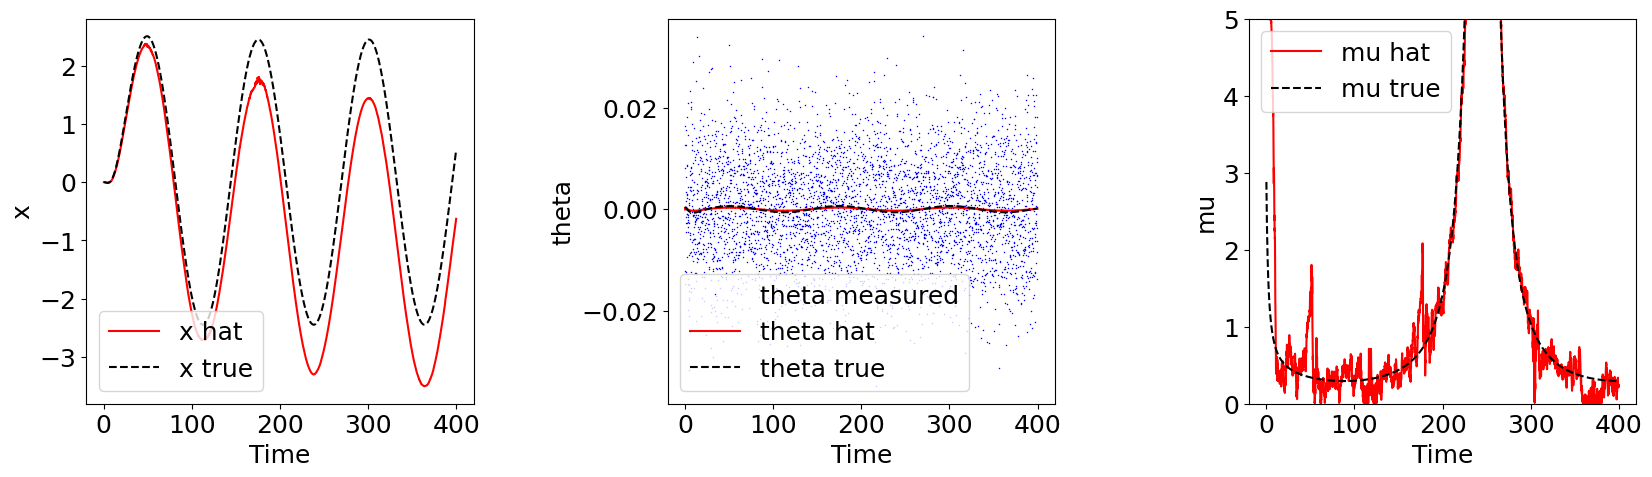

In [80]:
fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=0.5)


ax1 = fig.add_subplot(131)
plot_tme(tsim, x, None, x_hat, label_var='x', ax=ax1)

ax2 = fig.add_subplot(132)
plot_tme(tsim, theta, Ynoisy[0,:], theta_hat, label_var='theta', ax=ax2)

ax3 = fig.add_subplot(133)
plot_tme(tsim, mu, None, mu_hat, label_var='mu', ax=ax3)
ax3.set_ylim(0,5)

(-1.0, 1.0)

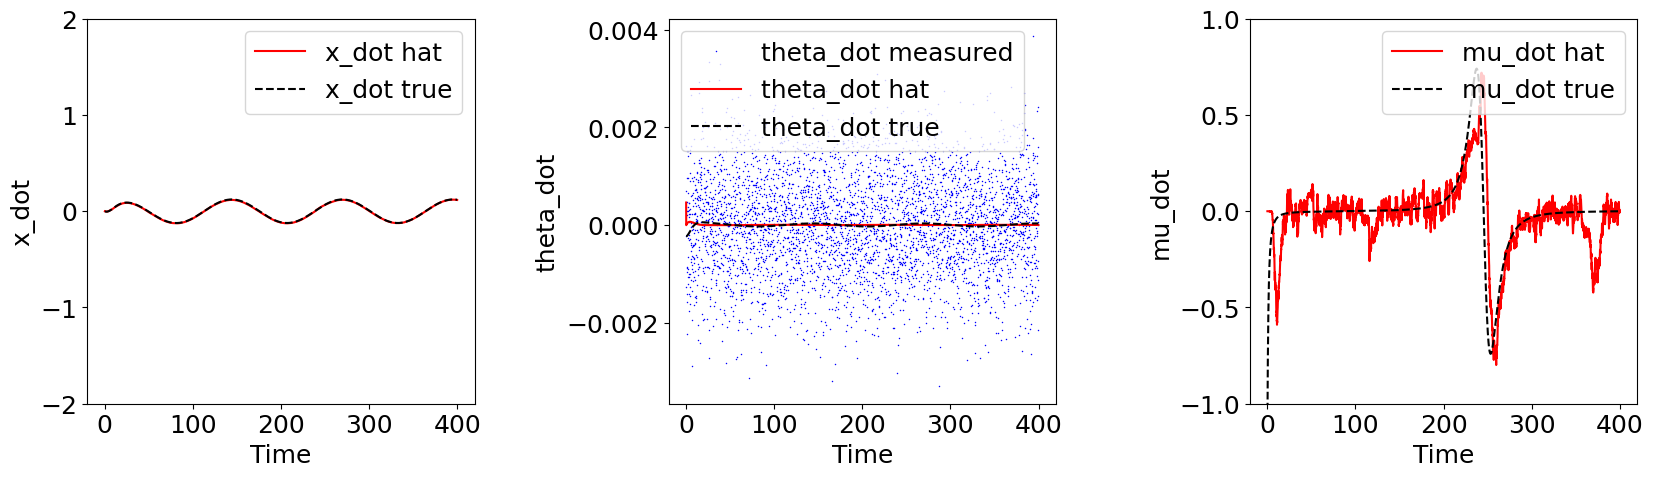

In [81]:
fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=0.5)


ax1 = fig.add_subplot(131)
plot_tme(tsim, x_dot, None, x_dot_hat, label_var='x_dot', ax=ax1)
ax1.set_ylim(-2,2)

ax2 = fig.add_subplot(132)
plot_tme(tsim, theta_dot, Ynoisy[1,:], theta_dot_hat, label_var='theta_dot', ax=ax2)

ax3 = fig.add_subplot(133)
plot_tme(tsim, mu_dot, None, mu_dot_hat, label_var='mu_dot', ax=ax3)
ax3.set_ylim(-1, 1)